## **1. Necessary Import**

In [ ]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import random
from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from  tensorflow.keras.optimizers import Adam
from  tensorflow.keras.utils import to_categorical
from  tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

## **2. Urban Sound Dataset Loading**

In [ ]:
audio_path = '/content/drive/MyDrive/MinorProject/USC'
metadata_path = '/content/drive/MyDrive/MinorProject/USC/UrbanSound8K.csv'

In [ ]:
metadata = pd.read_csv(metadata_path)
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


# **3. Methods for Performance Metrics Measures & Graph Plotting**

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    return train_score, test_score

In [ ]:
def model_evaluation_report(model, X_train, y_train, X_test, y_test, calc_normal=True):
    dash = '-' * 38
    train_score, test_score = evaluate_model(model, X_train, y_train, X_test, y_test)
    
    print('{:<10s}{:>14s}{:>14s}'.format("", "LOSS", "ACCURACY"))
    print(dash)
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Training:", train_score[0], 100 * train_score[1]))
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Test:", test_score[0], 100 * test_score[1]))
    if (calc_normal):
        max_err = max(train_score[0], test_score[0])
        error_diff = max_err - min(train_score[0], test_score[0])
        normal_diff = error_diff * 100 / max_err
        print('{:<10s}{:>13.2f}{:>1s}'.format("Normal diff ", normal_diff, ""))

In [ ]:
def acc_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("darkgrid")
  plt.plot(m.history['accuracy'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_accuracy'],color='#641E16',marker='h')
  plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def loss_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("darkgrid")
  plt.plot(m.history['loss'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_loss'],color='#641E16',marker='h')
  plt.title('Loss comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def acc_per_class(np_probs_array):    
    accs = []
    for idx in range(0, np_probs_array.shape[0]):
        correct = np_probs_array[idx][idx].astype(int)
        total = np_probs_array[idx].sum().astype(int)
        acc = (correct / total) * 100
        accs.append(acc)
    return accs

In [ ]:
class AdamW(Adam):  
    
    def __init__(self, learning_rate, gamma_init=1e-5, decay_rate=0.8, **kwargs):
        super().__init__(**kwargs)
        self.learning_rate = learning_rate
        self.gamma_init = gamma_init
        self.decay_rate = decay_rate
    
    def optimize(self, idx, layers, grads, epoch_num, steps):
        gamma = self.gamma_init * self.decay_rate ** int(epoch_num / 5) 
        dW = grads[f'dW{idx}']
        db = grads[f'db{idx}']
        self.m[f'W{idx}'] = self.beta1 * self.m[f'W{idx}'] + (1 - self.beta1) * dW
        self.v[f'W{idx}'] = self.beta2 * self.v[f'W{idx}'] + (1 - self.beta2) * dW ** 2 

        self.m[f'b{idx}'] = self.beta1 * self.m[f'b{idx}'] + (1 - self.beta1) * db
        self.v[f'b{idx}'] = self.beta2 * self.v[f'b{idx}'] + (1 - self.beta2) * db ** 2 

        mt_w  = self.m[f'W{idx}'] / (1 - self.beta1 ** steps)
        vt_w = self.v[f'W{idx}'] / (1 - self.beta2 ** steps)

        mt_b  = self.m[f'b{idx}'] / (1 - self.beta1 ** steps)
        vt_b = self.v[f'b{idx}'] / (1 - self.beta2 ** steps)

        w_update = - self.learning_rate * mt_w / ((np.sqrt(vt_w) + self.epsilon) + gamma * layers[idx].W) 
        b_update = - self.learning_rate * mt_b / ((np.sqrt(vt_b) + self.epsilon) + gamma * layers[idx].b)

        layers[idx].W += w_update
        layers[idx].b += b_update

# **4. Loading Extracted MFCCs**

In [ ]:
X = np.load("/content/drive/MyDrive/MinorProject/USC/X-mfcc.npy")
y = np.load("/content/drive/MyDrive/MinorProject/USC/y-mfcc.npy")

# **5.  Data Pre-processing & Normalizing**

In [ ]:
indexes = []
total = 8262 
indexes = list(range(0, total))
random.shuffle(indexes) #Randomizing Indexes

In [ ]:
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

In [ ]:
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]

In [ ]:
#Spliting the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

In [ ]:
#Also spliting metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

In [ ]:
print("--------------------Test Data Details--------------------")
print("Test split: {} ".format(len(test_meta)))
print("X test shape: {} ".format(X_test.shape))
print("y test shape: {} ".format(y_test.shape))
print("--------------------Train Data Details--------------------")
print("Train split: {}".format(len(train_meta)))
print("X train shape: {}".format(X_train.shape))
print("y train shape: {}".format(y_train.shape))

--------------------Test Data Details--------------------
Test split: 1652 
X test shape: (1652, 40, 174) 
y test shape: (1652,) 
--------------------Train Data Details--------------------
Train split: 6610
X train shape: (6610, 40, 174)
y train shape: (6610,)


In [ ]:
num_rows = 40
num_columns = 174
num_channels = 1

In [ ]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

In [ ]:
# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

In [ ]:
# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

# CNN-1  Model

In [ ]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate), input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))

    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))

    
    model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_labels, activation='softmax'))
    return model



In [ ]:
#Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005
#Calling Model
model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 83, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 83, 64)        0

In [ ]:
adam =keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=50, validation_split=1/12., verbose=1)

Epoch 1/50
48/48 [==============================] - 39s 143ms/step - loss: 2.3598 - accuracy: 0.1159 - val_loss: 2.3456 - val_accuracy: 0.1089
Epoch 2/50
48/48 [==============================] - 5s 114ms/step - loss: 2.3229 - accuracy: 0.1139 - val_loss: 2.3084 - val_accuracy: 0.1089
Epoch 3/50
48/48 [==============================] - 5s 114ms/step - loss: 2.2826 - accuracy: 0.1139 - val_loss: 2.2804 - val_accuracy: 0.1089
Epoch 4/50
48/48 [==============================] - 5s 115ms/step - loss: 2.2495 - accuracy: 0.1137 - val_loss: 2.2455 - val_accuracy: 0.1198
Epoch 5/50
48/48 [==============================] - 6s 115ms/step - loss: 2.2160 - accuracy: 0.1246 - val_loss: 2.2168 - val_accuracy: 0.1361
Epoch 6/50
48/48 [==============================] - 6s 115ms/step - loss: 2.1903 - accuracy: 0.1570 - val_loss: 2.1961 - val_accuracy: 0.1670
Epoch 7/50
48/48 [==============================] - 6s 115ms/step - loss: 2.1647 - accuracy: 0.1896 - val_loss: 2.1711 - val_accuracy: 0.1851
Epoch

In [ ]:
labels = ['Air Conditioner', 'Car Horn', 'Children Playing', 'Dog bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

In [ ]:
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         1.5066       47.7156
Test:             1.5327       47.0339
Normal diff          1.70 


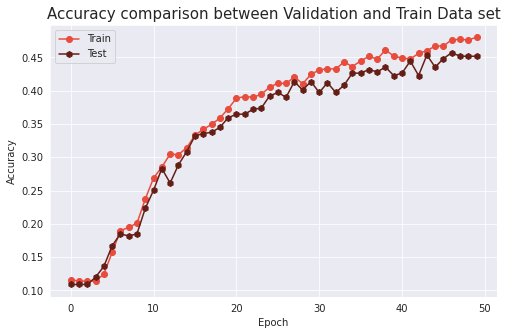

In [ ]:
acc_plot(history)

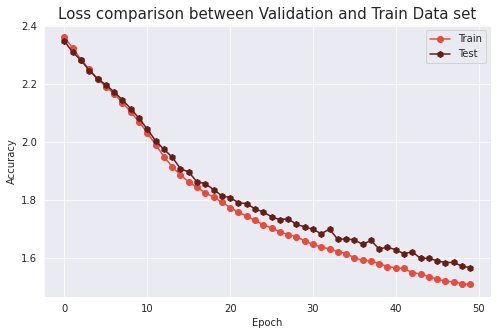

In [ ]:
loss_plot(history)

In [ ]:
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1) #Getting predicted labels
y_trues = np.argmax(y_test_encoded, axis=1)

In [ ]:


cm = confusion_matrix(y_trues, yhat_probs)
cm



array([[ 82,   0,   9,   7,   3,  34,   0,  35,   5,  24],
       [  0,   4,   8,  22,   0,   1,   8,   4,   3,  25],
       [  9,   0,  66,  34,   7,  17,   0,   8,  32,  47],
       [  6,   0,   9, 117,   6,   6,  16,   3,  13,  14],
       [  9,   3,  10,  14,  80,   3,  10,  43,   6,  27],
       [ 29,   0,   3,  10,   0,  97,   1,   9,   3,  28],
       [  6,   0,   0,  21,   0,   0,  35,   1,   0,   0],
       [ 55,   0,   4,   5,  28,  12,   5,  66,   0,  15],
       [  8,   0,   8,   7,   0,   7,   1,   0, 126,   3],
       [ 17,   0,  10,   1,   5,  10,   0,   4,  19, 104]])

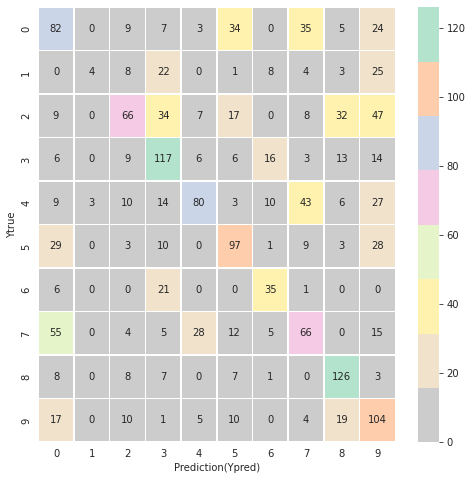

In [ ]:


def display_cm():
  CM = confusion_matrix(y_trues, yhat_probs)
  f, ax = plt.subplots(figsize=(8,8))
  sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.Pastel2_r)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()
display_cm()



In [ ]:
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)
print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.37      0.41      0.39       199
        Car Horn       0.57      0.05      0.10        75
Children Playing       0.52      0.30      0.38       220
        Dog bark       0.49      0.62      0.55       190
        Drilling       0.62      0.39      0.48       205
   Engine Idling       0.52      0.54      0.53       180
        Gun Shot       0.46      0.56      0.50        63
      Jackhammer       0.38      0.35      0.36       190
           Siren       0.61      0.79      0.69       160
    Street Music       0.36      0.61      0.46       170

        accuracy                           0.47      1652
       macro avg       0.49      0.46      0.44      1652
    weighted avg       0.49      0.47      0.46      1652



In [ ]:
accuracies = acc_per_class(cm)
pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
8,Siren,78.750000
3,Dog bark,61.578947
9,Street Music,61.176471
6,Gun Shot,55.555556
5,Engine Idling,53.888889
0,Air Conditioner,41.206030
4,Drilling,39.024390
7,Jackhammer,34.736842
2,Children Playing,30.000000
1,Car Horn,5.333333


# **CNN with AdamW and cyclical learning rate**

**Cyclical Learning rate**

In [ ]:
clr = CyclicLR(
    base_lr=0.001,
    max_lr=0.005,
    step_size=2000,
    mode='triangular')

In [ ]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate), input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    
    model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_labels, activation='softmax'))
    return model

In [ ]:

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=AdamW)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=250, validation_split=1/12., verbose=1,  callbacks=[clr])

Epoch 1/250
51/51 [==============================] - 7s 129ms/step - loss: 0.2745 - accuracy: 0.9360 - val_loss: 0.4033 - val_accuracy: 0.8875
Epoch 2/250
51/51 [==============================] - 6s 126ms/step - loss: 0.2752 - accuracy: 0.9373 - val_loss: 0.4960 - val_accuracy: 0.8639
Epoch 3/250
51/51 [==============================] - 6s 126ms/step - loss: 0.2704 - accuracy: 0.9411 - val_loss: 0.4199 - val_accuracy: 0.8802
Epoch 4/250
51/51 [==============================] - 6s 126ms/step - loss: 0.2706 - accuracy: 0.9384 - val_loss: 0.4003 - val_accuracy: 0.8766
Epoch 5/250
51/51 [==============================] - 6s 127ms/step - loss: 0.2669 - accuracy: 0.9389 - val_loss: 0.3963 - val_accuracy: 0.8857
Epoch 6/250
51/51 [==============================] - 6s 126ms/step - loss: 0.2648 - accuracy: 0.9404 - val_loss: 0.4170 - val_accuracy: 0.8693
Epoch 7/250
51/51 [==============================] - 7s 128ms/step - loss: 0.2601 - accuracy: 0.9442 - val_loss: 0.4227 - val_accuracy: 0.8748

In [ ]:
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.1156       98.5023
Test:             0.2710       93.1598
Normal diff         57.33 


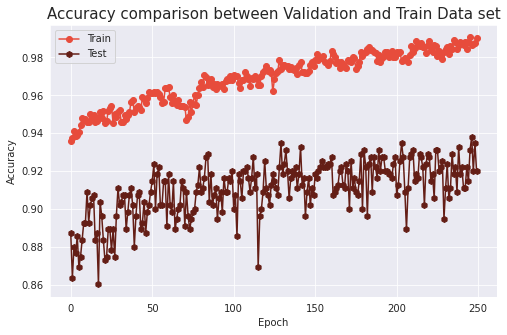

In [ ]:
acc_plot(history)

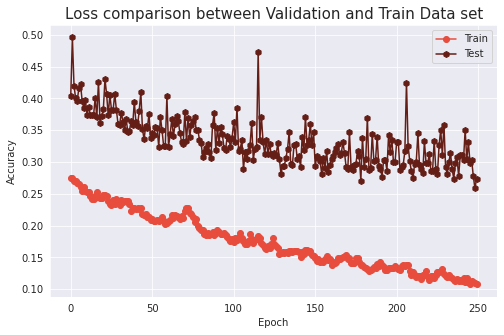

In [ ]:
loss_plot(history)

In [ ]:
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1) #Getting predicted labels
y_trues = np.argmax(y_test_encoded, axis=1)

In [ ]:


cm = confusion_matrix(y_trues, yhat_probs)
cm



array([[203,   0,   4,   2,   1,   0,   0,   1,   1,   5],
       [  1,  71,   0,   1,   0,   1,   0,   2,   0,   0],
       [  3,   0, 170,   0,   2,   0,   0,   0,   3,   4],
       [  4,   0,   7, 168,   1,   1,   0,   0,   0,   0],
       [  1,   0,   1,   2, 184,   0,   1,   1,   0,   3],
       [  4,   1,   0,   1,   2, 175,   0,   1,   0,   1],
       [  0,   0,   0,   4,   0,   0,  77,   0,   0,   0],
       [  1,   0,   0,   0,   8,   0,   0, 179,   0,   0],
       [  0,   1,   1,   0,   2,   0,   0,   0, 171,   2],
       [  6,   2,  15,   2,   4,   0,   0,   1,   1, 141]])

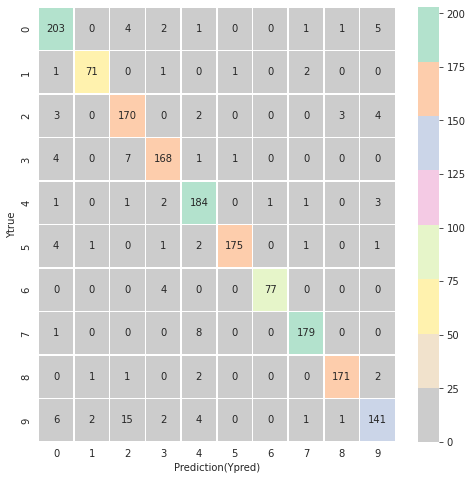

In [ ]:


def display_cm():
  CM = confusion_matrix(y_trues, yhat_probs)
  f, ax = plt.subplots(figsize=(8,8))
  sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.Pastel2_r)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()
display_cm()



In [ ]:
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)
print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.91      0.94      0.92       217
        Car Horn       0.95      0.93      0.94        76
Children Playing       0.86      0.93      0.89       182
        Dog bark       0.93      0.93      0.93       181
        Drilling       0.90      0.95      0.93       193
   Engine Idling       0.99      0.95      0.97       185
        Gun Shot       0.99      0.95      0.97        81
      Jackhammer       0.97      0.95      0.96       188
           Siren       0.97      0.97      0.97       177
    Street Music       0.90      0.82      0.86       172

        accuracy                           0.93      1652
       macro avg       0.94      0.93      0.93      1652
    weighted avg       0.93      0.93      0.93      1652



In [ ]:


accuracies = acc_per_class(cm)
pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies}).sort_values(by="ACCURACY", ascending=False)



,CLASS,ACCURACY
8,Siren,96.610169
4,Drilling,95.336788
7,Jackhammer,95.212766
6,Gun Shot,95.061728
5,Engine Idling,94.594595
0,Air Conditioner,93.548387
1,Car Horn,93.421053
2,Children Playing,93.406593
3,Dog bark,92.817680
9,Street Music,81.976744


# **VGG 16 Architecture**








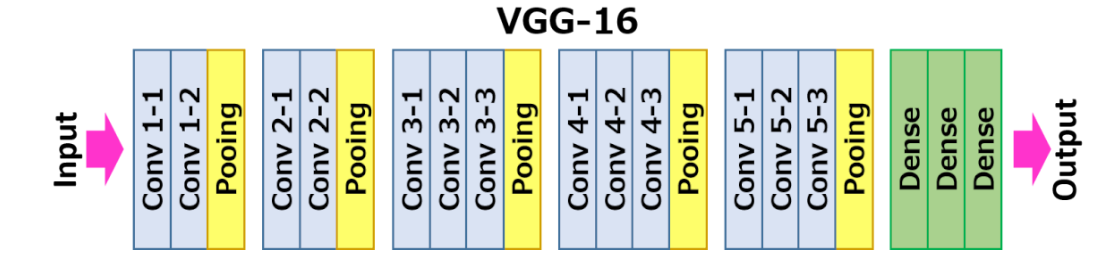

In [ ]:
from keras.layers import Dense, Activation, Flatten

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(40,174,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 174, 64)       640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 174, 64)       36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 87, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 87, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 87, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 43, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 43, 256)       2

In [ ]:

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=AdamW)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:


history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=200, validation_split=1/12.,  callbacks=[clr], verbose=1)



Epoch 1/200
48/48 [==============================] - 74s 714ms/step - loss: 2.2674 - accuracy: 0.1243 - val_loss: 2.2326 - val_accuracy: 0.1434
Epoch 2/200
48/48 [==============================] - 28s 574ms/step - loss: 2.1456 - accuracy: 0.1683 - val_loss: 1.9841 - val_accuracy: 0.2650
Epoch 3/200
48/48 [==============================] - 28s 575ms/step - loss: 1.9079 - accuracy: 0.2687 - val_loss: 1.7974 - val_accuracy: 0.3158
Epoch 4/200
48/48 [==============================] - 28s 575ms/step - loss: 1.7480 - accuracy: 0.3174 - val_loss: 1.6496 - val_accuracy: 0.3230
Epoch 5/200
48/48 [==============================] - 28s 575ms/step - loss: 1.6408 - accuracy: 0.3611 - val_loss: 1.6263 - val_accuracy: 0.3539
Epoch 6/200
48/48 [==============================] - 28s 574ms/step - loss: 1.5531 - accuracy: 0.3978 - val_loss: 1.5199 - val_accuracy: 0.3975
Epoch 7/200
48/48 [==============================] - 28s 574ms/step - loss: 1.4743 - accuracy: 0.4233 - val_loss: 1.4180 - val_accuracy:

In [ ]:
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.0529       99.1377
Test:             0.4345       92.9177
Normal diff         87.83 


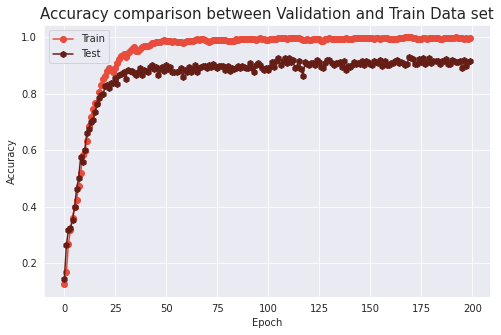

In [ ]:
acc_plot(history)

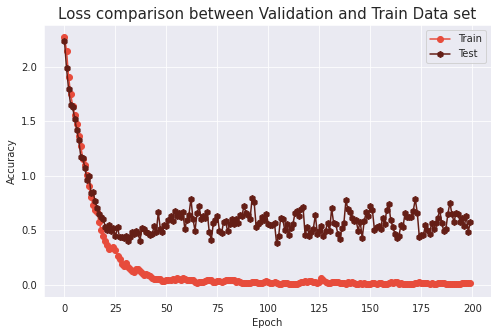

In [ ]:
loss_plot(history)

In [ ]:
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1) #Getting predicted labels
y_trues = np.argmax(y_test_encoded, axis=1)


cm = confMinorProjection_matrix(y_trues, yhat_probs)
cm



array([[192,   0,   0,   0,   0,   0,   0,   3,   0,   3],
       [  0,  77,   1,   1,   0,   0,   0,   0,   0,   3],
       [  3,   1, 157,   9,   0,   0,   0,   0,   1,   5],
       [  3,   2,   8, 174,   2,   0,   0,   1,   0,   3],
       [  0,   3,   2,   1, 165,   0,   1,   6,   0,   7],
       [  3,   0,   4,   0,   0, 190,   1,   0,   2,   1],
       [  0,   0,   0,   1,   1,   0,  76,   0,   0,   0],
       [  1,   0,   1,   0,   7,   0,   0, 193,   0,   2],
       [  2,   1,   4,   0,   0,   0,   0,   0, 148,   1],
       [  5,   1,   4,   2,   0,   0,   0,   2,   2, 163]])

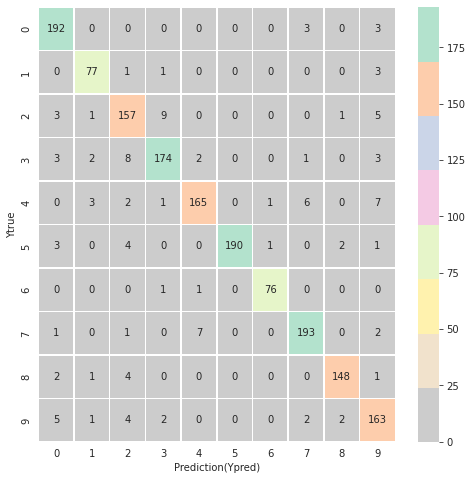

In [ ]:


def display_cm():
  CM = confMinorProjection_matrix(y_trues, yhat_probs)
  f, ax = plt.subplots(figsize=(8,8))
  sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.Pastel2_r)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()
display_cm()



In [ ]:
labels = ['Air Conditioner', 'Car Horn', 'Children Playing', 'Dog bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

In [ ]:
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)
print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.92      0.97      0.94       198
        Car Horn       0.91      0.94      0.92        82
Children Playing       0.87      0.89      0.88       176
        Dog bark       0.93      0.90      0.91       193
        Drilling       0.94      0.89      0.92       185
   Engine Idling       1.00      0.95      0.97       201
        Gun Shot       0.97      0.97      0.97        78
      Jackhammer       0.94      0.95      0.94       204
           Siren       0.97      0.95      0.96       156
    Street Music       0.87      0.91      0.89       179

        accuracy                           0.93      1652
       macro avg       0.93      0.93      0.93      1652
    weighted avg       0.93      0.93      0.93      1652



In [ ]:
accuracies = acc_per_class(cm)
pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,97.435897
0,Air Conditioner,96.969697
8,Siren,94.871795
7,Jackhammer,94.607843
5,Engine Idling,94.527363
1,Car Horn,93.902439
9,Street Music,91.061453
3,Dog bark,90.155440
2,Children Playing,89.204545
4,Drilling,89.189189
